<a href="https://colab.research.google.com/github/Vidi005/Klasifikasi-3-Varietas-Beras/blob/master/Klasifikasi%20Varietas%20Beras%20VGG-16Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi 3 Varietas Beras**

# Mengambil *Dataset* dari *Github*

In [0]:
!apt-get install subversion > /dev/null

!svn export https://github.com/Vidi005/Klasifikasi-3-Varietas-Beras/trunk/data > /dev/null

## Persiapan

Program ini dibuat untuk membedakan 3 varietas beras yaitu :

1.   Varietas Beras Basmathi
2.   Varietas Beras IR 64
3.   Varietas Beras Ketan

Pada program ini menggunakan metode *Convolutional Neural Network* (CNN) untuk melakukan klasifikasinya.

## Memasukan Fungsi *Library*

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

TensorFlow 2.x selected.


## Mengimpor Dataset

In [4]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls data/image
!ls data/image/train
!ls data/image/train/Basmathi
!ls data/image/train/IR64
!ls data/image/train/Ketan

test  train
Basmathi  IR64	Ketan
B10.jpg  B19.jpg  B27.jpg  B35.jpg  B43.jpg  B51.jpg  B5.jpg   B68.jpg	B7.jpg
B11.jpg  B1.jpg   B28.jpg  B36.jpg  B44.jpg  B52.jpg  B60.jpg  B69.jpg	B8.jpg
B12.jpg  B20.jpg  B29.jpg  B37.jpg  B45.jpg  B53.jpg  B61.jpg  B6.jpg	B9.jpg
B13.jpg  B21.jpg  B2.jpg   B38.jpg  B46.jpg  B54.jpg  B62.jpg  B70.jpg
B14.jpg  B22.jpg  B30.jpg  B39.jpg  B47.jpg  B55.jpg  B63.jpg  B71.jpg
B15.jpg  B23.jpg  B31.jpg  B3.jpg   B48.jpg  B56.jpg  B64.jpg  B72.jpg
B16.jpg  B24.jpg  B32.jpg  B40.jpg  B49.jpg  B57.jpg  B65.jpg  B73.jpg
B17.jpg  B25.jpg  B33.jpg  B41.jpg  B4.jpg   B58.jpg  B66.jpg  B74.jpg
B18.jpg  B26.jpg  B34.jpg  B42.jpg  B50.jpg  B59.jpg  B67.jpg  B75.jpg
I10.jpg  I19.jpg  I27.jpg  I35.jpg  I43.jpg  I51.jpg  I5.jpg   I68.jpg	I7.jpg
I11.jpg  I1.jpg   I28.jpg  I36.jpg  I44.jpg  I52.jpg  I60.jpg  I69.jpg	I8.jpg
I12.jpg  I20.jpg  I29.jpg  I37.jpg  I45.jpg  I53.jpg  I61.jpg  I6.jpg	I9.jpg
I13.jpg  I21.jpg  I2.jpg   I38.jpg  I46.jpg  I54.jpg  I62.jpg  I70.jpg
I14.

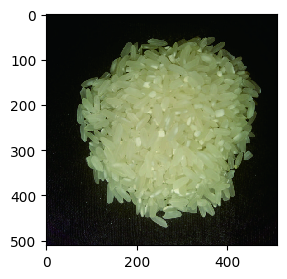

In [5]:
#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread("data/image/train/IR64/I17.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [6]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('data/image/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Basmathi', 'IR64', 'Ketan']

for i,label in enumerate(labels):
    folder = os.path.join("data/image/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 180 images belonging to 3 classes.
Found 45 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 3)
Bentuk array dari dataset validation (validasi) adalah: (45, 224, 224, 3) (45, 3)
Bentuk array dari dataset test (pengujian) adalah: (45, 224, 224, 3) (45,)


## Menyimpan Label

In [7]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Basmathi': 0, 'IR64': 1, 'Ketan': 2}


In [8]:
!cat labels.txt

Basmathi
IR64
Ketan

# Membuat Model dari Jaringan CNN yang Sudah dipelajari Sebelumnya (*pre-trained convnets*)

In [9]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model VGG16Net
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

58892288/58889256 [==============================] - 1s 0us/step


## *Feature Extraction*

Menggunakan model *pre-trained* untuk ekstraksi fitur (*feature extraction*) : Ketika bekerja dengan dataset kecil, adalah umum untuk mengambil keuntungan dari fitur yang dipelajari oleh model yang dilatih pada dataset yang lebih besar dalam domain yang sama. Ini dilakukan dengan membuat contoh model *pre-trained* dan menambahkan classifier yang sepenuhnya terhubung di atas. Model *pre-trained* adalah "beku" dan hanya bobot pengklasifikasi yang diperbarui selama pelatihan. Dalam hal ini, basis konvolusional mengekstraksi semua fitur yang terkait dengan setiap gambar dan Anda baru saja melatih classifier yang menentukan kelas gambar mengingat set fitur yang diekstraksi.

In [10]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Mengelompokkan Klasifikasi Tiga Jenis Beras dengan *Deep learning* (*Convolutional Neural Network*)

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

In [11]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Mempersiapkan Data Masukkan Pengujian

In [0]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

## Pembuatan Model (Menambah Model)

In [13]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3,activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 64)          294976    
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 15,009,859
Trainable params: 295,171
Non-trainable params: 14,714,688
_________________________________________________________________


## Pelatihan

In [14]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
#ckpt = ModelCheckpoint("Klasifikasi Beras Tumpukan.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit_generator(train_generator, 
                    epochs=100, 
                    validation_data=val_generator)
#history = model.fit(x = X_train3, y = y_train3, batch_size=120, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

Epoch 1/100
2/2 [==============================] - 16s 8s/step - loss: 1.4769 - acc: 0.3389 - val_loss: 1.2713 - val_acc: 0.3333
Epoch 2/100
2/2 [==============================] - 2s 1s/step - loss: 1.1539 - acc: 0.4333 - val_loss: 0.9892 - val_acc: 0.3556
Epoch 3/100
2/2 [==============================] - 3s 1s/step - loss: 0.9544 - acc: 0.4444 - val_loss: 0.8960 - val_acc: 0.4222
Epoch 4/100
2/2 [==============================] - 3s 1s/step - loss: 0.7797 - acc: 0.5833 - val_loss: 0.6480 - val_acc: 0.7778
Epoch 5/100
2/2 [==============================] - 2s 1s/step - loss: 0.6727 - acc: 0.7500 - val_loss: 0.5145 - val_acc: 0.8889
Epoch 6/100
2/2 [==============================] - 3s 1s/step - loss: 0.5772 - acc: 0.7722 - val_loss: 0.4149 - val_acc: 0.9778
Epoch 7/100
2/2 [==============================] - 2s 1s/step - loss: 0.5016 - acc: 0.8000 - val_loss: 0.4185 - val_acc: 0.8444
Epoch 8/100
2/2 [==============================] - 3s 1s/step - loss: 0.4408 - acc: 0.8333 - val_loss: 

## Menggambarkan Hasil Pelatihan

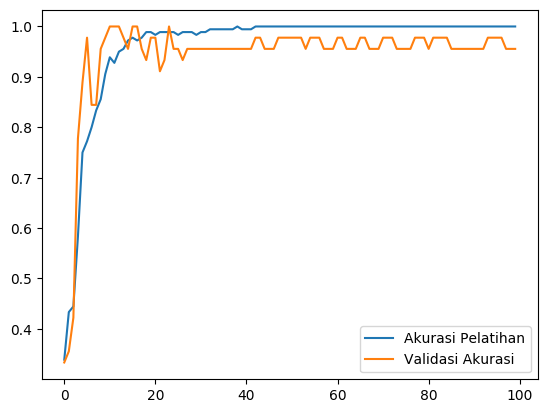

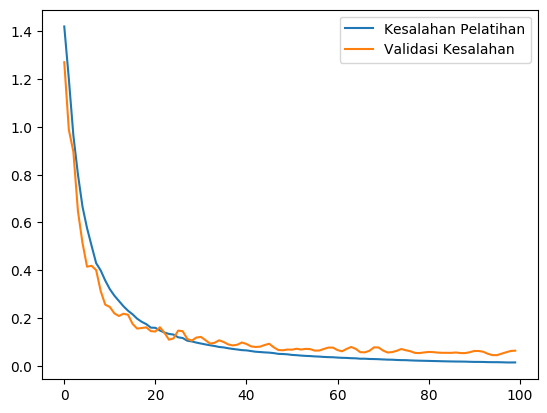

In [15]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [16]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


## Menggunakan Model

In [17]:
print(train_generator)

In [18]:
#Prediksi Label Validasi dengan Pelatihan
n = 44
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [1. 0. 0.]
Prediksinya adalah [9.9979168e-01 1.8782165e-08 2.0828920e-04]


Hasil tersebut merupakan hasil prediksi dari training dari 3 jenis data pelatihan yaitu jenis beras Basmathi, IR 64, dan Ketan. Menggunakan inputan gambar dengan piksel 224 x 224, arsitektur VGG16Net dengan ekstraksi fitur, dan 1 filter keluaran tambahan dengan fungsi aktivasi softmax

## Evaluasi

In [19]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
2/2 [==============================] - 2s 1s/step - loss: 0.0118 - acc: 1.0000
[0.01175051974132657, 1.0]
1/1 [==============================] - 1s 517ms/step - loss: 0.0632 - acc: 0.9556
[0.06315843015909195, 0.95555556]
45/1 [====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [20]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]


## Prediksi Gambar Individual

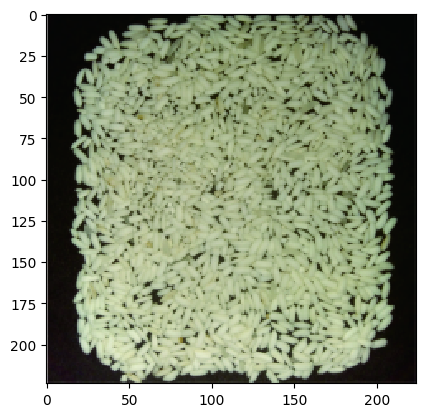

Label yang benar adalah: 2 : Ketan
Nilai yang diprediksi adalah: [6.0396993e-05 5.4288419e-05 9.9988532e-01]
Label yang diprediksi adalah: 2 : Ketan
Prediksi benar


In [21]:
n = 44 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

## *Confusion Matrix*

Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.93 0.07]
 [0.   0.   1.  ]]


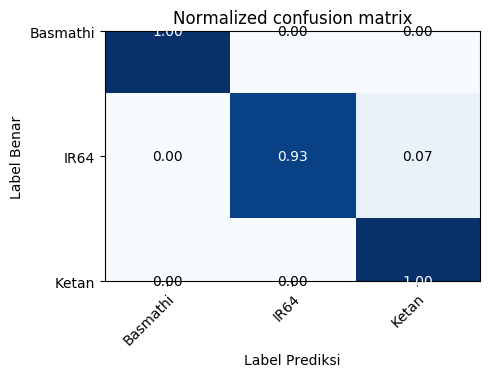

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    Fungsi ini menampilkan dan plotting matriks kebingungan (confusion matrix).
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Menghitung matriks kebingungan
    cm = confusion_matrix(y_true, y_pred)    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)    
    # Menampilkan semua nama label
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # Memberi label dengan daftar entri masing-masing.
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')
    
    # Memutar nama label dan mengatur perataannya.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Simpulkan dimensi data dan buat anotasi teks.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

# Menyimpan dan Konversi ke ".tflite"

Menyimpan model menggunakan tf.saved_model.save dan kemudian mengonversi model tersimpan ke format yang kompatibel tf lite.

In [23]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_3_Jenis_Beras.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/model/assets
